# Summary
In Season 12, the strike zone formula is this:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.90,
                 minroll
                 + 0.35*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 13, the strike zone formula is modified. The The max possible value for a strike goes DOWN from 0.90 to 0.85, and the ruthlessness coefficient goes DOWN from 0.35 to 0.30. This formula holds for Season 13 and Season 14:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.85,
                 minroll
                 + 0.3*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 15, the strike zone formula changes slightly *again*. The max possible value for a strike goes UP from 0.85 to 0.86, and the ruthlessness coefficient goes DOWN from 0.3 to 0.285 (a 5% decrease):
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.86,
                 minroll
                 + 0.285*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```


In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

In [2]:
all_files = glob.glob("../roll_data/*-strikes.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string"}) for f in all_files), ignore_index=True)

# select season (zero indexed)
# seasons = [11,12,13,14]
season = 18
df = df[df['season'] == season]


flinch_data = False

## Helper function definitions

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    if ("LATE_TO_PARTY" in ptm) and (row["day"] == 72) and ("OVERPERFORMING" not in ptm):
        ptm += ";OVERPERFORMING"
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if ("TRAVELING" in ptm) or ("TRAVELING" in pm):
        pass # sometimes traveling doesn't do anything on pitchers, but not always
        # if not row["top_of_inning"]:
            # mul += 0.05
            # attrs = "pitcher_coldness"
    if ("HIGH_PRESSURE" in ptm) or ("HIGH_PRESSURE" in pm):
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # pass # sometimes growth doesn't do anything on pitchers, but not always
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # attrs = "pitcher_coldness"
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    #     # NVGs allow the player to play 50% better in a solar eclipse.
    #     # This might affect fielding and baserunning as well?
    #     # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
    #     # Did anyone with this mod *ever* pitch???
    #     mul += 0.50
    return mul, attrs


def get_batter_mul(row):
    # if row[["runner_name"]].isna().any():
    # row["runner_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    if ("LATE_TO_PARTY" in btm) and (row["day"] == 72) and ("OVERPERFORMING" not in btm):
        btm += ";OVERPERFORMING"
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if ("TRAVELING" in btm) or ("TRAVELING" in bm):
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if ("HIGH_PRESSURE" in btm) or ("HIGH_PRESSURE" in bm):
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # correct multiplier for musclitude only
        mul += 1.0
        attrs = "batter_musclitude"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # correct multiplier for musclitude only
        mul += 0.15
        attrs = "batter_musclitude"
    if "ON_FIRE" in bm:
        # correct for moxie only, I think
        mul += 2.0
        attrs = "batter_moxie"
        # pass
    return mul, attrs

## Apply multipliers to data

In [4]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")

df[["pitcher_mul", "pitcher_mul_attrs"]] = df.apply(get_pitcher_mul, axis=1, result_type="expand")

# df["ruth_scaled"] = df["pitcher_ruthlessness"] * df["pitcher_mul"]
# df["cold_scaled"] = df["pitcher_coldness"] * df["pitcher_mul"]
df["ruth_scaled"] = df.apply(
        lambda x: x["pitcher_ruthlessness"] * x["pitcher_mul"]
        if (x["pitcher_mul_attrs"] == "") or ("pitcher_ruthlessness" in x["pitcher_mul_attrs"])
        else x["pitcher_ruthlessness"],
        axis=1,)
df["cold_scaled"] = df.apply(
        lambda x: x["pitcher_coldness"] * x["pitcher_mul"]
        if (x["pitcher_mul_attrs"] == "") or ("pitcher_coldness" in x["pitcher_mul_attrs"])
        else x["pitcher_coldness"],
        axis=1,)

# df["opw_scaled"] = df["pitcher_overpowerment"] * df["pitcher_mul"]
# df["unthwk_scaled"] = df["pitcher_unthwackability"] * df["pitcher_mul"]
# df["shakes_scaled"] = df["pitcher_shakespearianism"] * df["pitcher_mul"]
# df["supp_scaled"] = df["pitcher_suppression"] * df["pitcher_mul"]

df["musc_scaled"] = df.apply(
        lambda x: x["batter_musclitude"] * x["batter_mul"]
        if (x["batter_mul_attrs"] == "") or ("batter_musclitude" in x["batter_mul_attrs"])
        else x["batter_musclitude"],
        axis=1,)
df["mox_scaled"] = df.apply(
        lambda x: x["batter_moxie"] * x["batter_mul"]
        if (x["batter_mul_attrs"] == "") or ("batter_moxie" in x["batter_mul_attrs"])
        else x["batter_musclitude"],
        axis=1,)
df["path_scaled"] = df["batter_patheticism"] * df["batter_mul"]


df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [5]:
# recenter ballpark factors: subtract 0.5
# for attr in ['ballpark_grandiosity',
#              'ballpark_fortification',
#              'ballpark_obtuseness',
#              'ballpark_ominousness',
#              'ballpark_inconvenience',
#              'ballpark_viscosity',
#              'ballpark_forwardness',
#              'ballpark_mysticism',
#              'ballpark_elongation',
#             ]:
#     df[attr] -= 0.50


In [6]:
# df = df[(df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)]

df["ruth_times_vibes"] = df["ruth_scaled"] * df["pitcher_vibes"]
df["ruth_vibes"] = df["ruth_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df["cold_vibes"] = df["cold_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
# df["opw_vibes"] = df["opw_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
# df["unthwk_vibes"] = df["unthwk_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
# df["shakes_vibes"] = df["shakes_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
# df["supp_vibes"] = df["supp_scaled"] * (1 + 0.2 * df["pitcher_vibes"])

df["musc_vibes"] = df["musc_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["mox_vibes"] = df["mox_scaled"] * (1 + 0.2 * df["batter_vibes"])

df["ruth_cold"] = (9 * df["ruth_vibes"] + 1 * df["cold_vibes"]) / 10

df["musc-mox"] = (df["musc_scaled"] - df["mox_scaled"])
df["abs_musc-mox"] = np.abs(df["musc_scaled"] - df["mox_scaled"])

df["musc_pow"] = df["musc_scaled"] ** 0.5
df["mox_pow"] = df["musc_scaled"] ** 1.5

df["musc_mox"] = df["musc_pow"] * df["mox_pow"]

df["batting_hype_pow"] = df["batting_team_hype"]**0.5
df["pitching_hype_pow"] = df["pitching_team_hype"]**0.5

df["hype_diff"] = df["pitching_team_hype"] - df["batting_team_hype"]

# put in our "best fit" up here in the original df, just because
if season == 11:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.35 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 12 or season == 13:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.30 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 14:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.285 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]

## Exclude data
Handles swapping between flinch and no-flinch situations, and excluding things like ON_FIRE.

In [30]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]
dfc = df.copy()
dfc = dfc[dfc["hype_diff"] == 0]
for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING", "SLOW_BUILD"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "GROWTH", "SINKING_SHIP", "TRAVELING", "SLOW_BUILD"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "SLOW_BUILD"]:
# for exclude_mod in ["PSYCHIC", "PARASITE", "SLOW_BUILD"]:
# for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    #     dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    #     dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc["flinch"] = (dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0)
    print(dfc.groupby("flinch").size())
    if flinch_data:
        dfc = dfc[dfc["flinch"]]
    else:
        dfc = dfc[~dfc["flinch"]]
#     dfc["flinch"] = dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)
# dfc.groupby("flinch").size()

for exclude_point in [#("7d782994-a4fb-469d-9942-e97def670e23", 168),
#                       ("61184762-0033-4334-8c0f-b68ad85b5a20", 272),
#                       ("61184762-0033-4334-8c0f-b68ad85b5a20", 275),
#                       ("b40f0955-f3b6-49ab-a6e8-497b71f10757", 192),
#                       ("18f2cc84-b5ad-49d7-87bc-f47afa8b2e81", 131),
#                       ("14c148b6-836b-4c9f-a68f-302c33b362aa", 88),
#                       ("b72a2eb5-df05-4d9d-a5d9-5e30737f3522", 216),
#                       ("08d140db-04b8-4a37-b22a-c032e511a45d", 23),
#                       ("d1dc6196-d972-4fe0-94e7-751592f772f2", 319),
#                       ("08d140db-04b8-4a37-b22a-c032e511a45d", 328),
                      # ("bcbac883-dad6-42b2-b73d-aa79bb908140", 254),
                     ]:
    # print(exclude_point[0], exclude_point[1])
    dfc = dfc[~((dfc["game_id"] == exclude_point[0]) & (dfc["play_count"] == exclude_point[1]))]

print(dfc.shape)


flinch
False    12687
True       332
dtype: int64
(12687, 235)


In [31]:
# print(list(df.columns))
print(len(df))
print(len(dfc))

97798
12687


In [32]:
digest_list = [
    "event_type",
    "roll",
    "threshold",
    "batter_name",
    "pitcher_name",
    "ruth_vibes",
    # "pitcher_vibes",
    "musc_scaled",
    "mox_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
    # "svc_best",
]

## SVC fit

In [73]:
# X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
X = dfc[["passed",
         "roll",
         # "ruth_vibes",
         # "cold_vibes",
         "ruth_cold",
         # "opw_vibes",
         # "shakes_vibes",
         # "supp_vibes",
         # "unthwk_vibes",
         "ballpark_forwardness",
         "hype_diff",
         # "pitching_team_hype",
         # "batting_team_hype",
         # "batting_hype_pow",
         # "pitching_hype_pow",
         # "musc_scaled",
         # "mox_scaled",
         "musc-mox",
         "abs_musc-mox",
         # "musc_pow",
         # "mox_pow",
         # "musc_mox",
         ]].copy()
X = X[X["roll"] < 0.86]
# X = X[X["musc-mox"] < 0]

# X["roll"] = X["roll"] - 0.2 * X["ballpark_forwardness"]
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop(["passed"], axis=1)
# X = X.drop(["musc-mox"], axis=1)
# print(X.loc[y, "roll"].max())
print(y.dtype)
# pin_intercept = 0.280
pin_intercept = None
pins = [
    # (0.290, "ruth_cold"),
    # (0.120, "ballpark_forwardness"),
    # (0.085, "musc-mox"),
    # (-0.035, "abs_musc-mox"),
    # (0.06, "pitching_team_hype"),
    # (-0.06, "batting_team_hype"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

print(X.shape)

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

bool
(9926, 6)
[[5180   12]
 [  24 4710]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5192
        True       1.00      0.99      1.00      4734

    accuracy                           1.00      9926
   macro avg       1.00      1.00      1.00      9926
weighted avg       1.00      1.00      1.00      9926

0.996373161394318
intercept: 0.2799258724278822
(0.29039778104981034, 'ruth_cold')
(0.12029083527604283, 'ballpark_forwardness')
(0.0, 'hype_diff')
(0.08453329158091849, 'musc-mox')
(-0.03605157510019791, 'abs_musc-mox')


## Calculate threshold from fit

In [70]:
if flinch_data:
    intercept = 0.50
else:
    intercept = 0.30
if season == 11:
    dfc["threshold"] = (intercept
                        + 0.35 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.90
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 12 or season == 13:
    dfc["threshold"] = (intercept
                        + 0.30 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.85
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 14:
    dfc["threshold"] = (intercept
                        + 0.285 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
# elif season == 18:
#     intercept = 0.346
#     dfc["threshold"] = (intercept
#                         + 0.285 * dfc["ruth_cold"] # + 0.285 * dfc["ruth_vibes"]
#                         + 0.12 * dfc["ballpark_forwardness"] # + 0.125 * dfc["ballpark_forwardness"]
#                         + 0.085 * dfc["musc-mox"] # + 0.08 * dfc["musc_scaled"]
#                         - 0.035 * dfc["abs_musc-mox"] # - 0.10 * dfc["mox_scaled"]
#                        )
#     dfc["svc"] = dfc["threshold"] - intercept
#     strikemax = 0.86
#     dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
else:
    intercept = intercept_scaled
    dfc["threshold"] = intercept_scaled
    print("intercept:", intercept_scaled)
    for pair in pins + list(zip(-np.array(coef_list), X.columns)):
        if "roll" not in pair[1]:
            print(pair)
            dfc["threshold"] += pair[0] * dfc[pair[1]]
    # dfc['threshold'] += 0.2 * dfc['ballpark_forwardness']
    dfc["svc"] = dfc["threshold"] - intercept_scaled
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax


intercept: 0.2799258724278822
(0.29039778104981034, 'ruth_cold')
(0.12029083527604283, 'ballpark_forwardness')
(0.0, 'hype_diff')
(0.08453329158091849, 'musc-mox')
(-0.03605157510019791, 'abs_musc-mox')


In [71]:
dfc_strikes = dfc[dfc["event_type"] == "StrikeLooking"]
dfc_flinch = dfc[dfc["event_type"] == "StrikeFlinching"]
dfc_balls = dfc[dfc["event_type"] == "Ball"]
dfc_flinch["roll"].max()

nan

## Find Outliers

season
18    36
dtype: int64


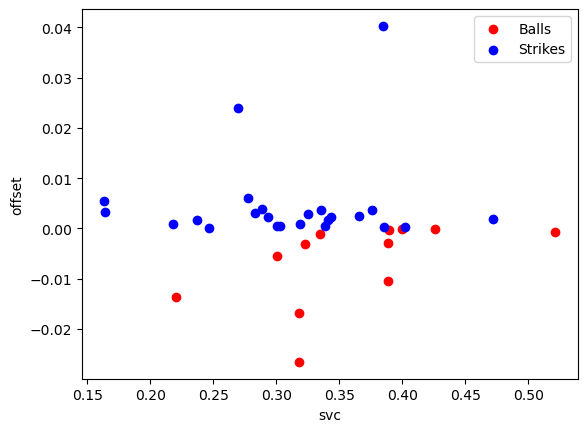

In [72]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
# outliers = outliers[outliers["musc-mox"] > 0]

fig, ax = plt.subplots(1)
x_val = "svc"
# x_val = "ruth_cold"
# x_val = "ballpark_forwardness"
# x_val = "musc-mox"
# x_val = "abs_musc-mox"
# x_val = "pitching_team_hype"
# x_val = "batting_team_hype"
# x_val = "hype_diff"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
table[
    [
        "event_type",
        "roll",
        "threshold",
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        "batter_mul",
        "pitcher_mul",
        "batting_team_hype",
        "pitching_team_hype",
        # "svc",
        # "ruth_vibes",
        # "cold_vibes",
        # "musc_scaled",
        # "mox_scaled",
        # "musc-mox",
        # "abs_musc-mox",
        # "ballpark_forwardness",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
         # 'ball_count',
         # 'strike_count',
         # 'out_count',
        # "home_score",
        # "away_score",
        "baserunner_count",
        # "is_maximum_blaseball",
    ]
].sort_values("offset")
# table.groupby(["pitching_team_mods"]).size()
# table.groupby(["pitching_team_hype"]).size()
print(outliers.groupby("season").size())

## Visualize Threshold

Text(0.5, 0.98, 'Season 19, Non-Flinching')

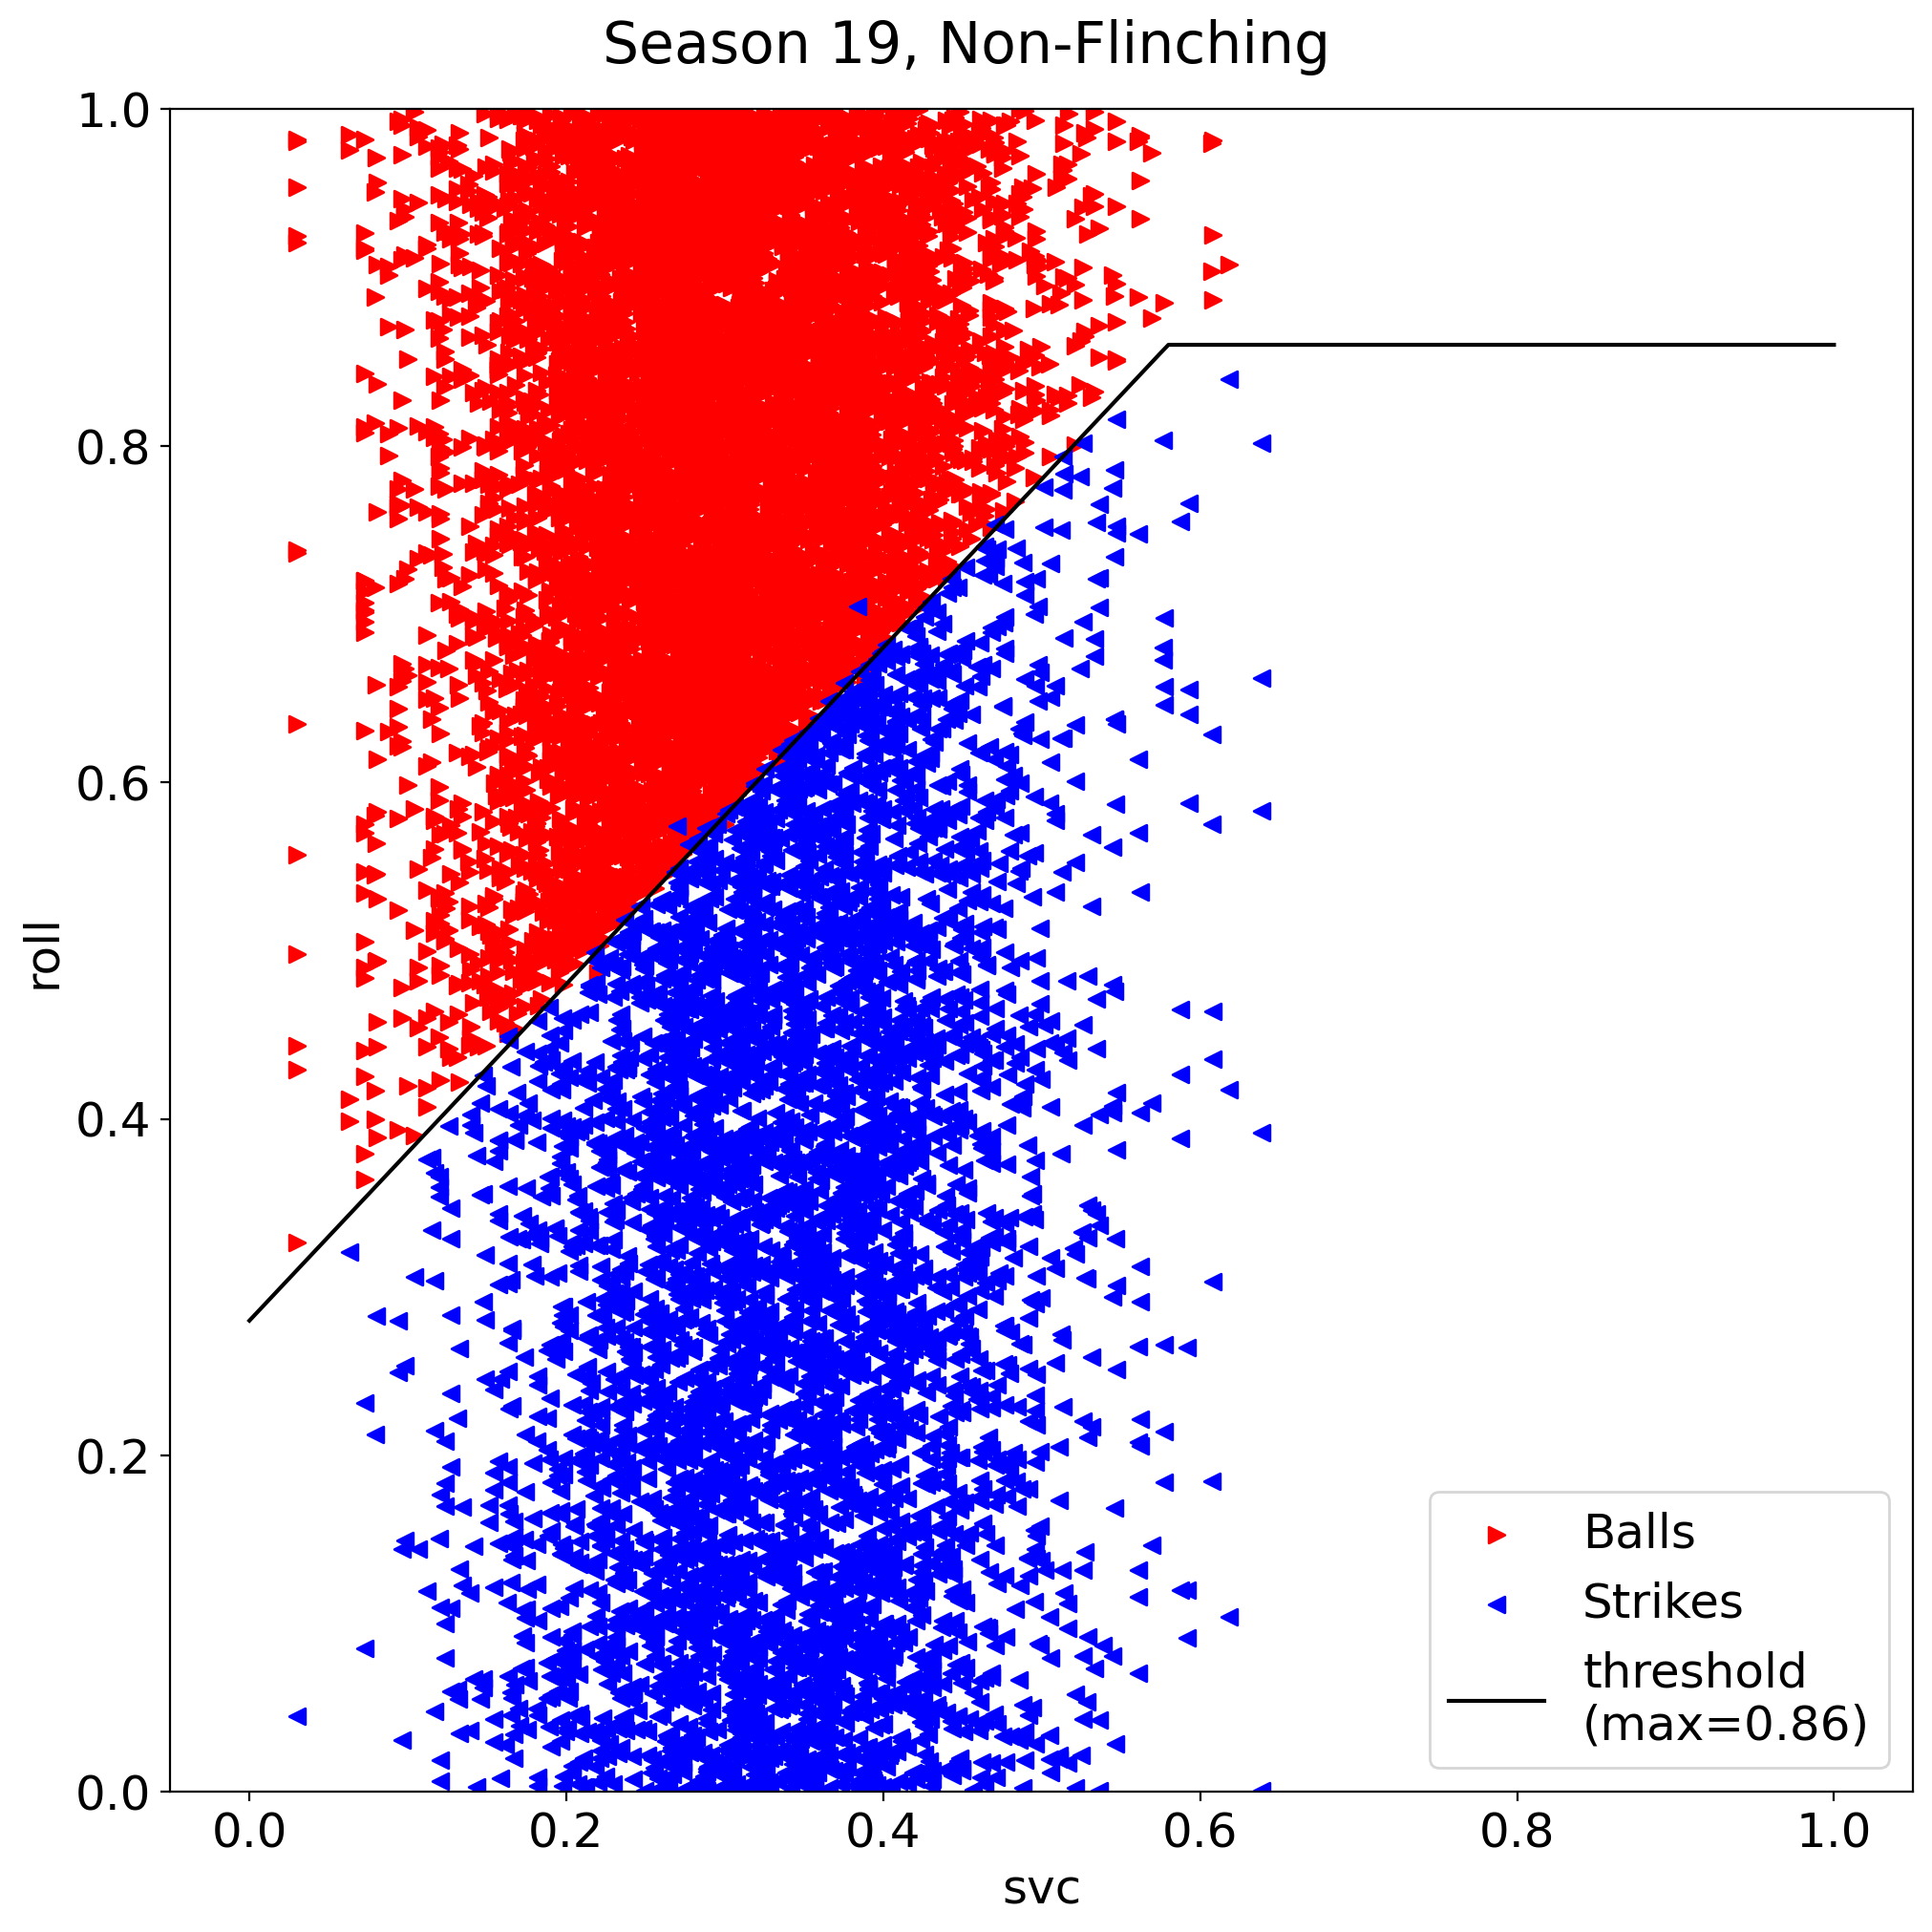

In [53]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "svc"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

intercept_plot = intercept
# intercept_plot = -intercept_scaled
xline = np.linspace(0, 1, 201)
# xline = np.insert(xline, 1, 0.65)
yline = intercept_plot + xline
# yline = xline
yline[(yline > strikemax)] = strikemax

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker="<",
)
# ax.set_xlim(-0.05, 1.05)
ax.plot(xline, yline, "k", label=f"threshold\n(max={strikemax})")
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="red", label="Balls (below threshold)", marker='<')
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="blue", label="Strikes (above threshold)", marker='>')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.plot(dfc["svc"].min(), 0.5, 'o')

ax.legend(loc="lower right")
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching")
# fig.savefig(f"../figures/strikes_s{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white', dpi=200)


In [54]:
outliers.groupby("season").size()

season
18    33
dtype: int64

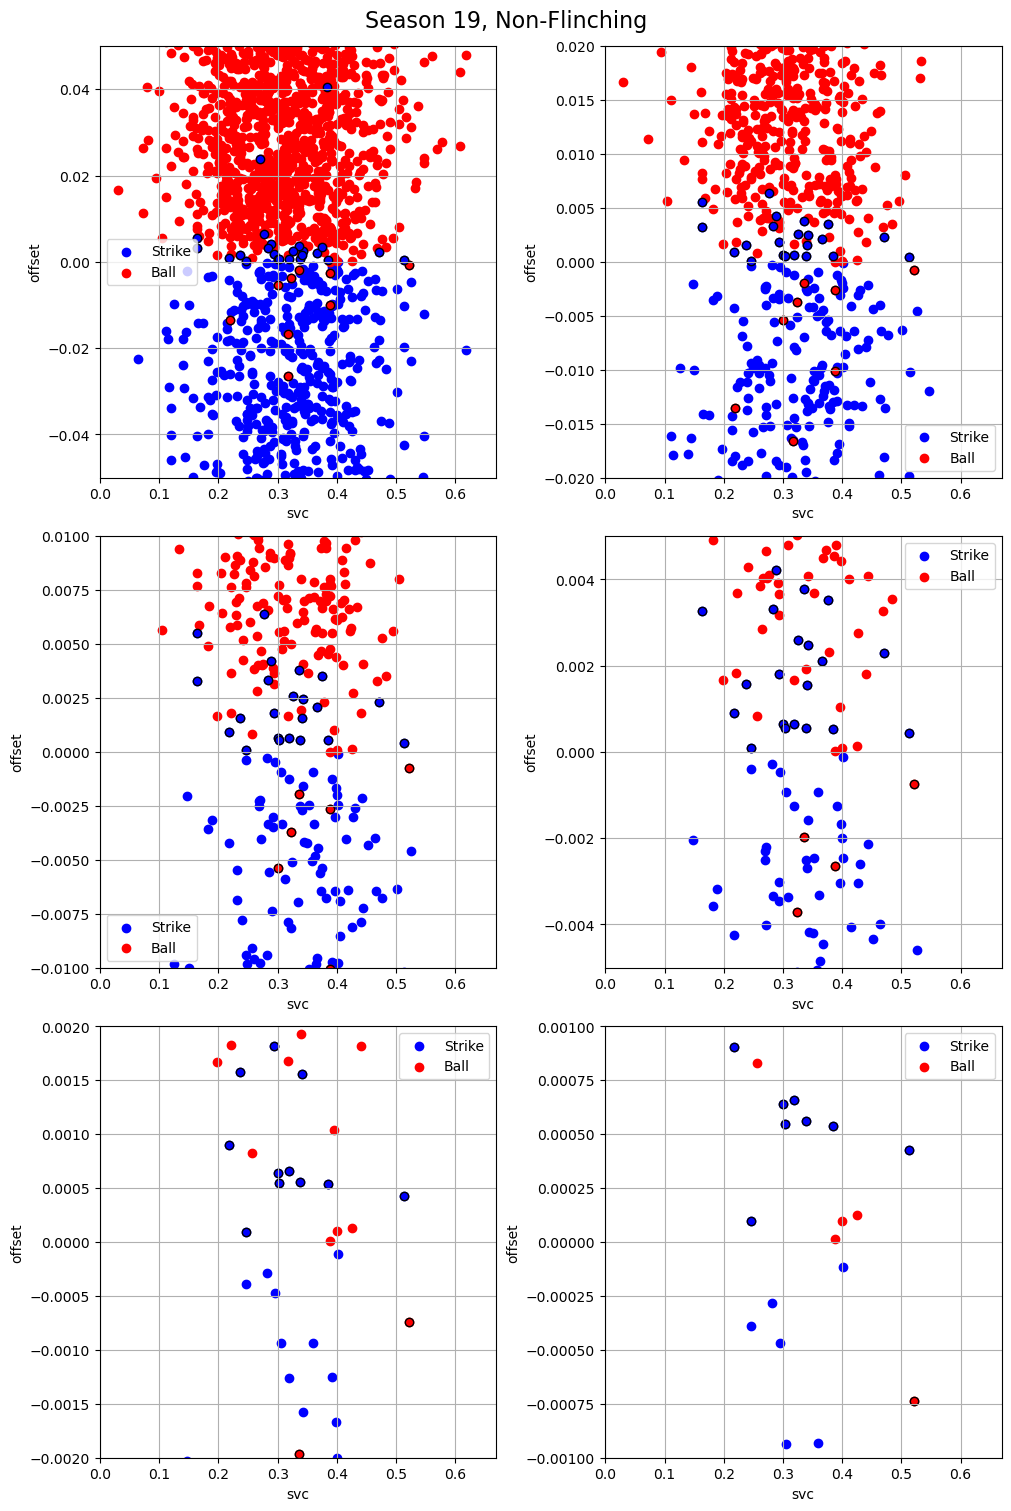

In [55]:
plt.rcParams["font.size"] = 10
x_val = "svc"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig(f"../figures/ball_strike_fit_offsets_season{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white')


In [56]:
# cutoff = 0.85 + intercept_scaled[0]
cutoff = 0.85 - intercept
print(round(cutoff, 6))
print(dfc_balls['roll'].max())
print(dfc_flinch['roll'].max())
print(dfc_strikes['roll'].max())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].min())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin())
# dfc_balls[dfc_balls['svc'] > cutoff].iloc[dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin(),:]
# print(dfc_flinch[dfc_flinch['svc'] > 0.85 + intercept_scaled[0]]['roll'].max())

0.569887
0.9999806832535514
nan
0.8394777676722414


In [57]:
print(dfc_balls['roll'].min())
print(dfc_flinch['roll'].min())
print(dfc_strikes['roll'].min())

0.3265759853975571
nan
0.0005312572265958


In [58]:
0.85 - intercept_scaled

0.569886966320424

In [59]:
# df["svc"].min()

In [48]:
# df["svc_best"].max()

In [22]:
# df.iloc[df["svc_best"].argmax(), :][70:]

In [23]:
# dfc["threshold"] = -1 * (\
#     1.0 * -0.20 + \
#     -0.30 * dfc["ruth_scaled"] + \
#     -0.20 * dfc["ballpark_forwardness"] + \
#     -0.10 * dfc["musc_scaled"] + \
#     -0.06 * dfc["ruth_vibes"])
# dfc["threshold"] = -1 * (\
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_scaled"] + \
#     coef_scaled[0,2] * dfc["ballpark_forwardness"] + \
#     coef_scaled[0,3] * dfc["ruth_vibes"] + \
#     coef_scaled[0,4] * dfc["musc_scaled"] + \
#     coef_scaled[0,5] * dfc["flinch"])
# dfc.loc[(dfc["threshold"] > 0.85), "threshold"] = 0.85


# dfc["offset"] = dfc["roll"] - dfc["threshold"]

# outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
# print(len(outliers))

# fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 10)
# x_val = "svc"
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Balls")
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Strikes")
# ax.set_xlabel(x_val)
# ax.set_ylabel('offset')
# ax.grid()
# ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
# fig.savefig("fit_outliers.png", facecolor='white')

In [24]:
dfc_flinch.loc[:,["roll", "ruth_vibes", "pitcher_name", "svc"]].sort_values("ruth_vibes")

,roll,ruth_vibes,pitcher_name,svc


In [25]:
dfc_flinch["svc"].min()

nan

In [26]:
df_strikes = df[df["event_type"] == "StrikeLooking"]
df_flinch = df[df["event_type"] == "StrikeFlinching"]
df_balls = df[df["event_type"] == "Ball"]

In [27]:
print(df_balls['roll'].min())
print(df_flinch['roll'].min())
print(df_strikes['roll'].min())

0.009235878301657
0.0004467073582588
4.970715327123898e-06


In [28]:
print(df_balls['roll'].max())
print(df_flinch['roll'].max())
print(df_strikes['roll'].max())

0.9999952780379446
0.8575403860443549
0.9284155441497186


In [29]:
game = dfc[(dfc["game_id"] == "7d782994-a4fb-469d-9942-e97def670e23") & (dfc["batter_name"] == "Zesty Yaboi")]
game[digest_list]

,event_type,roll,threshold,batter_name,pitcher_name,ruth_vibes,musc_scaled,mox_scaled,ballpark_forwardness,game_id,play_count
